# Badanie zawartości alkoholu na podstawie sposobów przygotowania piwa

Niniejsza analiza ma posłużyć określeniu zawartości alkoholu produktu gotowego na podstawie sposobów przygotowania i składników użytych przy produkcji piwa w domowych warunkach. Pozyskany został zbiór danych zawiera 75 tysięcy obserwacji. Poszczególnymi obserwacjami są przepisy zaciągnięte z serwisu Brewer's Friend, gdzie użytkownicy dzielą się swoimi recepturami z uwzględnieniem szczegółowych parametrów i materiałów użytych w warzeniu.

In [48]:
#potrzebne biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
#from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import levene,kruskal
from sklearn.preprocessing import LabelEncoder

In [2]:
#pandas options
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
#pd.set_option('display.max_rows', None)

Dane zostały załadowane z plików csv. Plik recipeData zawiera wszystkie potrzebne dane o recepturach. Natomiast plik styleData jest pomocnicznym plikiem zawierającym słownik nazw styli piwa z ich ID wymienionym również w kolumnie tabeli danych z recepturami.

In [3]:
#załadowanie danych
df_recipe = pd.read_csv("recipeData.csv")
df_recipe.rename(columns = {'Size(L)':'Size_L'},inplace = True)
df_style = pd.read_csv("styleData.csv")

## Opis zmiennych

Poniżej opisane zostały wszystkie zmienne w głównym pliku z recepturami wraz z określeniem skali wartości w nich zawartych. Zmienną zależną w analizie jest <font color = red>ABV </font>- czyli procentowa zawartość alkoholu.<br>
<br>
**Beer ID** - unikalny identyfikator rzędu <br>
**Name** - nazwa piwa -  skala nominalna <br>
**URL** - strona internetowa z której pochodzi przepis <br>
**Style** - typ piwa - skala nominalna<br>
**Style ID** - Numeric ID for type of brew<br>
**Size_L** - ilość gotowego produktu w litrach - skala ilorazowa<br>
**OG** - stosunek gęstości brzeczki<sup>1</sup> do wody przed fermentacją - skala ilorazowa (względna/Plato)<br>
**FG** - stosunek gęstości brzeczki<sup>1</sup> do wody po fermentacji - skala ilorazowa (względna/Plato)<br>
<font color = red>**ABV**</font> - procentowa zawartość alkoholu - skala ilorazowa<br>
**IBU**<sup>2</sup> - międzynarodowa jednostka odczuwalnej goryczy - skala porządkowa<br>
**Color**<sup>3</sup> - kolor brzeczki w standardzie - skala porządkowa<br>
**BoilSize** - ilość płynu przed gotowaniem w litrach- skala ilorazowa<br>
**BoilTime** - czas gotowania brzeczki<sup>1</sup> w minutach- skala przedziałowa<br>
**BoilGravity** - stosunek gęstości brzeczki<sup>1</sup> przed gotowaniem do gęstości wody - skala ilorazowa (względna/Plato)<br>
**Efficiency**  - efektywność ekstrakcji cukrów liczona w procentach - skala ilorazowa<br>
**MashThickness** - stosunek ilości wody do zboża - kwarty/funt albo litry/kilogramy - skala ilorazowa<br>
**SugarScale** - skala wykorzystana do określenia zawartości cukru - skala dychotomiczna<br>
**BrewMethod** - sposób warzenia piwa - skala nominalna <br>
**PitchRate** - ilość drożdzy liczona w jednostce - x milionów komórek/millitrów brzeczki/stopni Plato - m cells/ml/deg P<br>
**PrimaryTemp** - temperatura podczas fermentacji - stopnie celsjusza -skala przedziałowa<br>
**PrimingMethod** - <br>
**PrimingAmount** - ilość cukru lub ekstraktu słodowego dodawanego podczas butelkowania - różne skale wartości - skala nominalna <br>
**UserId** - id użytkownika, który dodał recepturę<br>
<br>
1. Brzeczka − półprodukt stosowany przy produkcji piwa, który jest efektem filtracji zacieru (przyp. https://pl.wikipedia.org/wiki/Brzeczka). <br>

2. Wybrane style piwa i ich scala IBU:
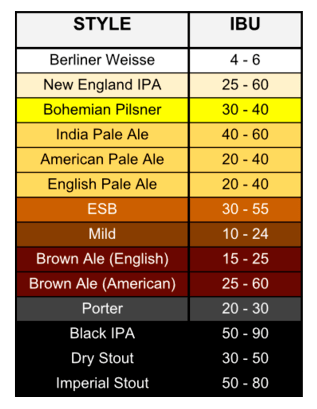

3. Skala kolorów piwa według metody SRM oraz EBC (przyp. https://redlionkegworth.co.uk/2019/11/beer-standard-reference-method-and-european-brewing-convention/):
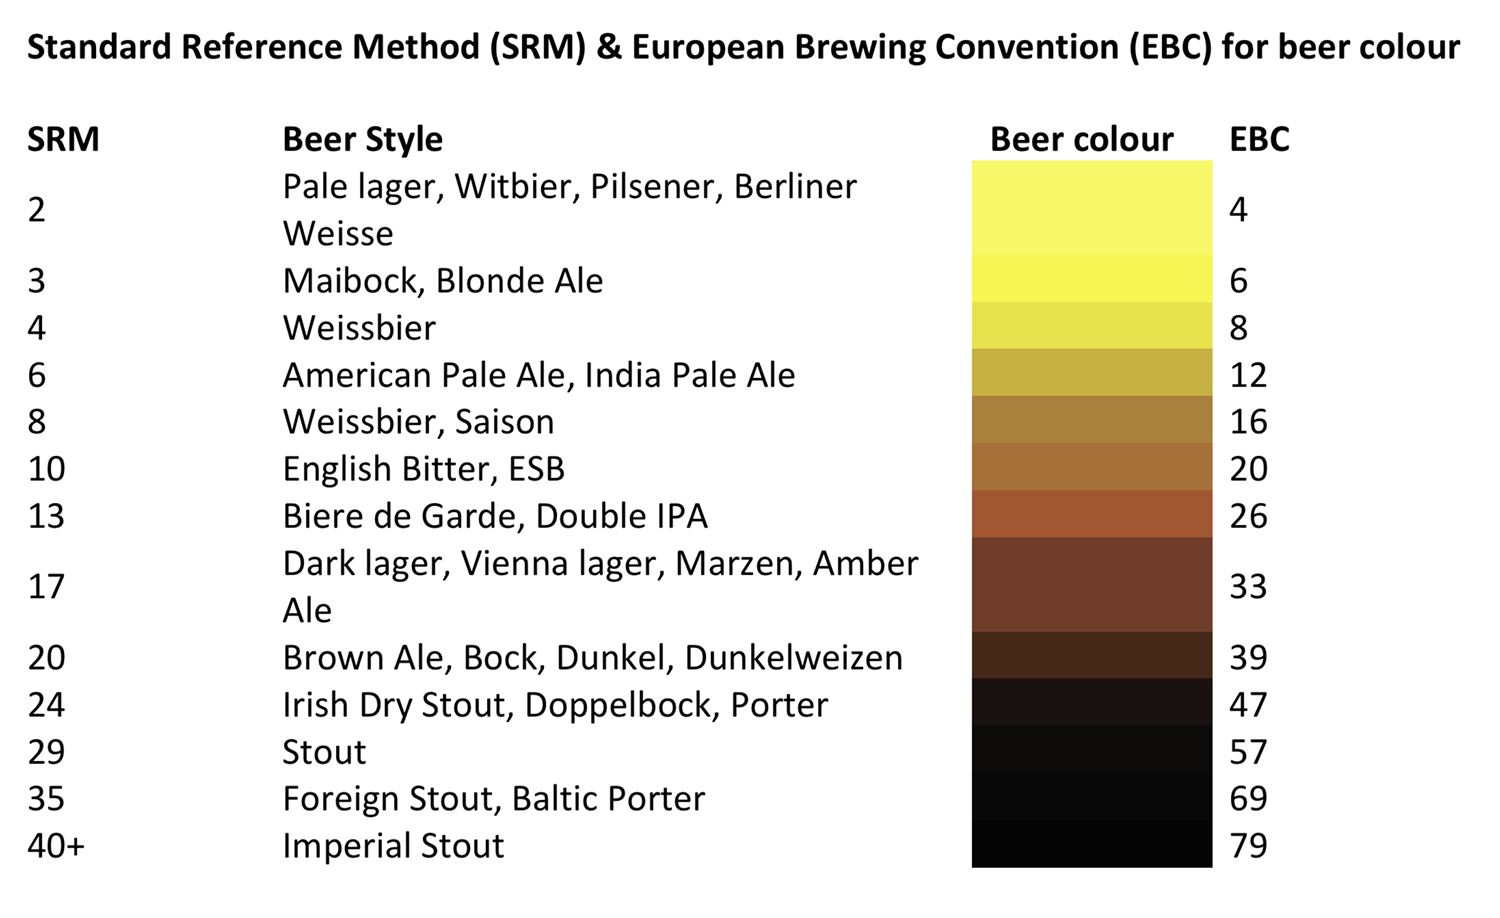

## Statystyki opisowe, analiza wartości skrajnych i braków danych

Ze względu na swoją całkowitą lub prawie całkowitą unikalność oraz nieużyteczność zmienne URL, Name, BeerID, UserID nie będą w żaden sposób analizowane.

### Analiza eksploracyjna zmiennych bez braków danych

In [4]:
count_missing = df_recipe.isnull().sum().rename('Liczba braków')
perc_missing = round((df_recipe.isnull().sum()/len(df_recipe)),4)*100
perc_missing = perc_missing.rename('% braków w zmiennej')
pd.concat([count_missing,perc_missing],axis =1)

,Liczba braków,% braków w zmiennej
BeerID,0,0.00
Name,1,0.00
URL,0,0.00
Style,596,0.81
StyleID,0,0.00
Size_L,0,0.00
OG,0,0.00
FG,0,0.00
ABV,0,0.00
IBU,0,0.00


In [5]:
#przegląd podsumowania danych
pd.set_option('display.max_colwidth', 100)
df_recipe.iloc[:5,:12]

,BeerID,Name,URL,Style,StyleID,Size_L,OG,FG,ABV,IBU,Color,BoilSize
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumking-clone,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-extract,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-all-grain,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgisk-blonde-50-l,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00


In [6]:
#przegląd podsumowania danych
pd.set_option('display.max_colwidth', 100)
df_recipe.iloc[:5,12:]

,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


**Statystyki opisowe zmiennych**

In [7]:
df_recipe.iloc[:,:12].describe()

,BeerID,StyleID,Size_L,OG,FG,ABV,IBU,Color,BoilSize
count,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000
mean,36931.000000,60.179432,43.929775,1.406266,1.075865,6.136865,44.276186,13.404989,49.724919
std,21321.978453,56.811462,180.373492,2.196908,0.432524,1.883510,42.945508,11.944511,193.246427
min,1.000000,1.000000,1.000000,1.000000,-0.003000,0.000000,0.000000,0.000000,1.000000
25%,18466.000000,10.000000,18.930000,1.051000,1.011000,5.080000,23.370000,5.170000,20.820000
50%,36931.000000,35.000000,20.820000,1.058000,1.013000,5.790000,35.770000,8.440000,27.440000
75%,55396.000000,111.000000,23.660000,1.069000,1.017000,6.830000,56.380000,16.790000,30.000000
max,73861.000000,176.000000,9200.000000,34.034500,23.424600,54.720000,3409.300000,186.000000,9700.000000


In [8]:
df_recipe.iloc[:,12:].describe()

,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp,UserId
count,73861.000000,70871.000000,73861.000000,43997.000000,34609.000000,51199.000000,23371.000000
mean,65.074870,1.353955,66.354881,2.127235,0.750468,19.175641,43078.069188
std,15.024228,1.930989,14.091686,1.682347,0.394262,4.219676,27734.252556
min,0.000000,0.000000,0.000000,0.000000,0.000000,-17.780000,49.000000
25%,60.000000,1.040000,65.000000,1.500000,0.350000,18.000000,20984.000000
50%,60.000000,1.047000,70.000000,1.500000,0.750000,20.000000,42897.000000
75%,60.000000,1.060000,75.000000,3.000000,1.000000,20.000000,57841.000000
max,240.000000,52.600000,100.000000,100.000000,2.000000,114.000000,134362.000000


In [9]:
pd.concat([df_recipe.iloc[:,:12].quantile(q=0.95).rename('Percentyl 95'),\
           df_recipe.iloc[:,:12].quantile(q=0.975).rename('Percentyl 97.5') \
          ,df_recipe.iloc[:,:12].quantile(q=0.99).rename('Percentyl 99')],axis = 1)

,Percentyl 95,Percentyl 97.5,Percentyl 99
BeerID,70168.000,72014.500000,73122.400000
StyleID,167.000,170.000000,175.000000
Size_L,58.000,150.000000,720.000000
OG,1.102,9.763290,14.598500
FG,1.026,1.754885,3.450578
ABV,9.290,10.370000,11.864000
IBU,104.680,129.750000,175.770000
Color,40.000,47.655000,50.000000
BoilSize,67.000,160.000000,760.108000


In [10]:
count_Style = df_recipe.Style.value_counts()/len(df_recipe)
sum_top_n = sum(count_Style[:5])

**Wizualizacja oraz analiza wartości skrajnych**

#### Zmienna Size_L, BoilSize

Text(0, 0.5, '')

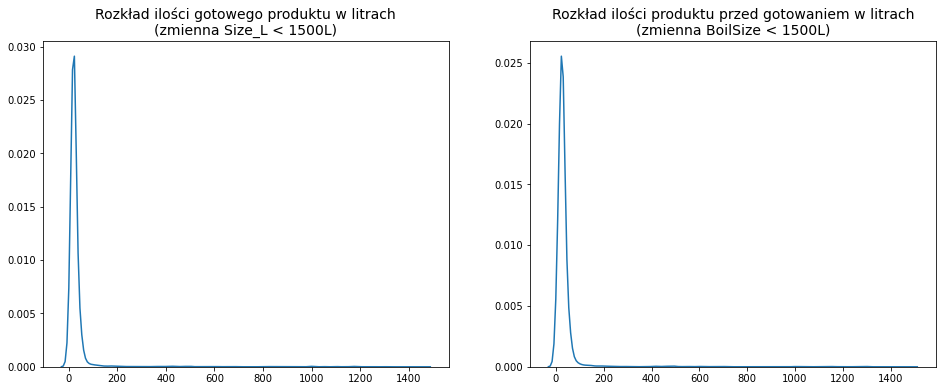

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(data = df_recipe[df_recipe.Size_L<1500], x='Size_L', ax=axes[0])
axes[0].set_title('Rozkład ilości gotowego produktu w litrach\n(zmienna Size_L < 1500L)',fontsize= 14)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

sns.kdeplot(data = df_recipe[df_recipe.BoilSize<1500], x='BoilSize', ax=axes[1])
axes[1].set_title('Rozkład ilości produktu przed gotowaniem w litrach\n(zmienna BoilSize < 1500L)',fontsize= 14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')


Należy rozważyć wykluczenie receptur, gdzie ilości uwarzonego/gotowanego produktu przekraczają pewną założoną wartość w litrach. Uwarunkowane jest to chemicznymi procesami, które np. w przypadku dużych kadzi niwelują potrzebę dogrzewania, gdyż sam proces wydziela odpowiednie ilości ciepła. W związku z tym dane zostaną ograniczone do receptur z ilością nie przekraczajacą 160L gotowanego produktu, a więc według 97.5 percentyla zmiennej BoilSize. Zatem 2.5% wartości tych zmiennych zostanie wykluczonych.

#### Zmienna ABV

Text(0.5, 1.0, 'Rozkład zawartości alkoholu produktu gotowego\n(zmienna ABV)')

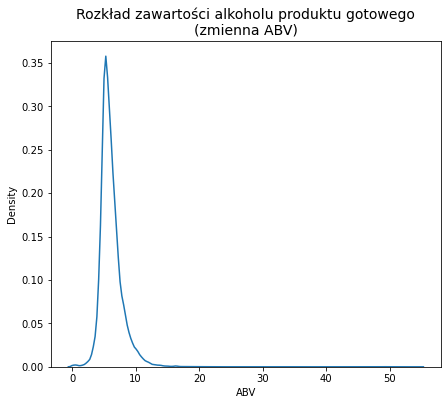

In [12]:
plt.figure(figsize=(7,6))

g = sns.kdeplot(data = df_recipe, x='ABV')
g.set_title('Rozkład zawartości alkoholu produktu gotowego\n(zmienna ABV)',fontsize= 14)

Zawartość alkoholu jest zmienną zależną i nie zostanie oczyszczona z wartości skrajnych, gdyż możliwe jest że uda się wykryć zmienną, której wartości wpływają na ekstremalnie wysoką zawartość alkoholu w gotowym produkcie.

#### Zmienna OG, FG, SugarScale

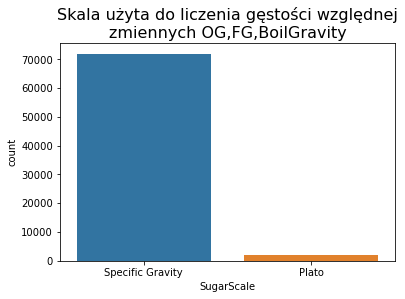

In [13]:
sns.countplot(data = df_recipe, x = 'SugarScale')
plt.title('Skala użyta do liczenia gęstości względnej\nzmiennych OG,FG,BoilGravity', fontsize = 16)
plt.show()

Zmienne dotyczące gęstości przed fermentacją (OG), gęstości po fermentacji (FG) oraz brzeczki przed gotowaniem (BoilGravity) liczone są w dwóch rodzajach skal - Plato lub gęstości względnej (specific gravity). Ze względu na przeważając liczbę receptur korzystających z metody gęstości względnej, zostaną dodane 3 kolumny, które w celu ujednolicenia wartości przeliczać będą wszystkie wartości w skali Plato na skalę względną. W tym momencie rozpatrzone będą zmienne OG i FG. Natomiast zmienna BoilGravity zostanie przekształcona, ale przeanalizowana dopiero w drugiej części ze względu na braki danych. <br>
<br>
Wzór użyty do przekształcenia pochodzi ze strony Brewer's Friend - źródło receptur - https://www.brewersfriend.com/plato-to-sg-conversion-chart/ <br>
<br>
***SG = 1+ (plato / (258.6 – ( (plato/258.2) *227.1) ) )***

In [14]:
def scale_Plato_to_SG(plato):
    sg = 1 + (plato/(258.6-((plato/258.2)*227.1)))
    return sg
df_scaled = df_recipe.copy()
df_scaled['OG_Specific'] = df_scaled.apply(lambda row: scale_Plato_to_SG(row['OG']) if row['SugarScale'] == 'Plato' else row['OG'], axis=1)
df_scaled['FG_Specific'] = df_scaled.apply(lambda row: scale_Plato_to_SG(row['FG']) if row['SugarScale'] == 'Plato' else row['FG'], axis=1)
df_scaled['BoilGravity_Specific'] = df_scaled.apply(lambda row: scale_Plato_to_SG(row['BoilGravity']) if row['SugarScale'] == 'Plato' else row['BoilGravity'], axis=1)

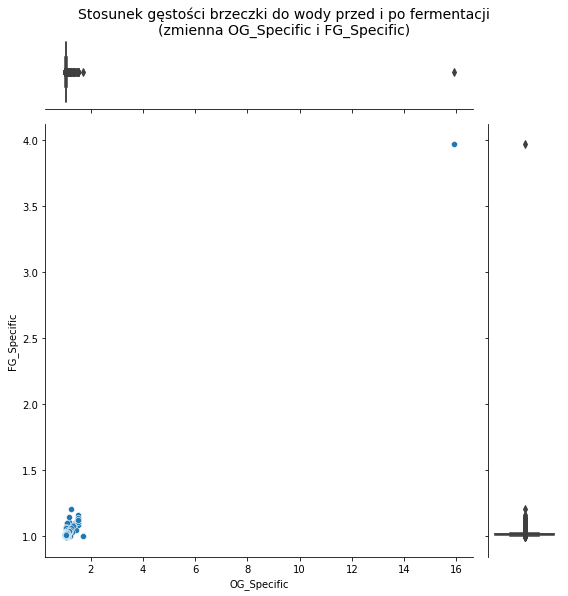

In [15]:
g = sns.JointGrid(data = df_scaled,x='OG_Specific', y='FG_Specific',height = 8)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.boxplot)

g.fig.suptitle('Stosunek gęstości brzeczki do wody przed i po fermentacji\n(zmienna OG_Specific i FG_Specific)',fontsize= 14, x= 0.5, y=1.03)

plt.show()

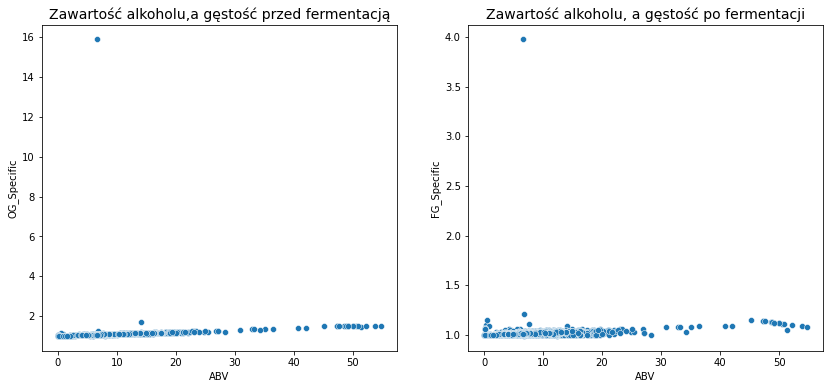

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.scatterplot(data = df_scaled,x='ABV', y='OG_Specific', ax=axes[0])
axes[0].set_title('Zawartość alkoholu,a gęstość przed fermentacją',fontsize= 14)
#axes[1,0].set_xlabel(fontsize =14)
#axes[1,0].set_ylabel(fontsize =14)

sns.scatterplot(data = df_scaled,x='ABV', y='FG_Specific', ax=axes[1])
axes[1].set_title('Zawartość alkoholu, a gęstość po fermentacji',fontsize= 14)
#axes[1,1].set_xlabel(fontsize =14)
#axes[1,1].set_ylabel(fontsize =14)

plt.show()


In [17]:
df_scaled[df_scaled.OG_Specific >15]

,BeerID,Name,URL,Style,StyleID,Size_L,OG,FG,ABV,IBU,...,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId,OG_Specific,FG_Specific,BoilGravity_Specific
8265,8266,English IPA V1,/homebrew/recipe/view/190453/english-ipa-v1,English IPA,65,6.61,15.897,3.974,6.6,57.1,...,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN,15.897,3.974,NaN


In [18]:
print('OG Specific',scale_Plato_to_SG(df_scaled[df_scaled.OG_Specific >15].OG.values),\
'FG Specific',scale_Plato_to_SG(df_recipe[df_scaled.OG_Specific >15].FG.values))
df_scaled.OG_Specific.iloc[8265] = scale_Plato_to_SG(df_scaled.OG_Specific.iloc[8265])
df_scaled.FG_Specific.iloc[8265] = scale_Plato_to_SG(df_scaled.FG_Specific.iloc[8265])
df_scaled.iloc[8265]

OG Specific [1.0649871] FG Specific [1.01557792]


C:\Users\Marcel\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


BeerID                                                         8266
Name                                                 English IPA V1
URL                     /homebrew/recipe/view/190453/english-ipa-v1
Style                                                   English IPA
StyleID                                                          65
Size_L                                                         6.61
OG                                                           15.897
FG                                                            3.974
ABV                                                             6.6
IBU                                                            57.1
Color                                                          10.3
BoilSize                                                       7.86
BoilTime                                                         90
BoilGravity                                                     NaN
Efficiency                                      

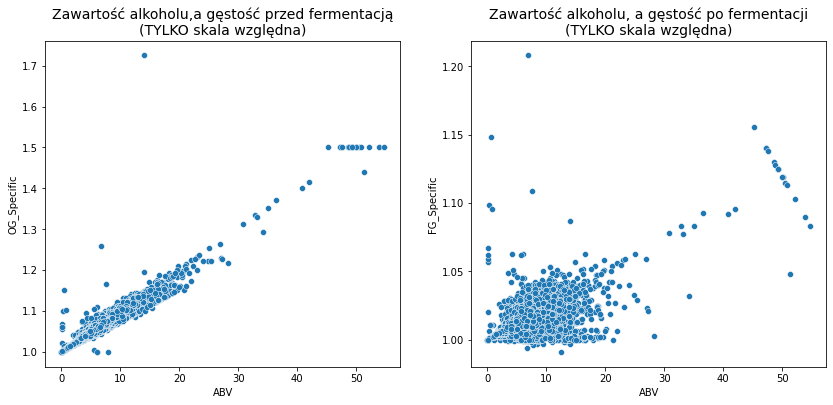

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.scatterplot(data = df_scaled,x='ABV', y='OG_Specific', ax=axes[0])
axes[0].set_title('Zawartość alkoholu,a gęstość przed fermentacją\n(TYLKO skala względna)',fontsize= 14)
#axes[1,0].set_xlabel(fontsize =14)
#axes[1,0].set_ylabel(fontsize =14)

sns.scatterplot(data = df_scaled,x='ABV', y='FG_Specific', ax=axes[1])
axes[1].set_title('Zawartość alkoholu, a gęstość po fermentacji\n(TYLKO skala względna)',fontsize= 14)
#axes[1,1].set_xlabel(fontsize =14)
#axes[1,1].set_ylabel(fontsize =14)

plt.show()

Wykres punktowy wspólny dla OG i FG w skali względnej gęstości wskazuje na występowanie jednej wartości skrajnej. Przeliczenie wartości na skalę względną zwraca prawidłowe wyniki więc można uznać, że zmienna SugarScale == SpecificGravity jest nieprawidłowa i w rzeczywistości jest to wynik w skali Plato. W związu z tym, również ta obserwacja zostanie przekształcona do skali względnej. Porównując wartości każdej z tych zmiennych do zawartości alkoholu wskazują, że wyższe wartości zmiennych wpływają na wyższy wynik ABV.

#### Zmienna Color, IBU

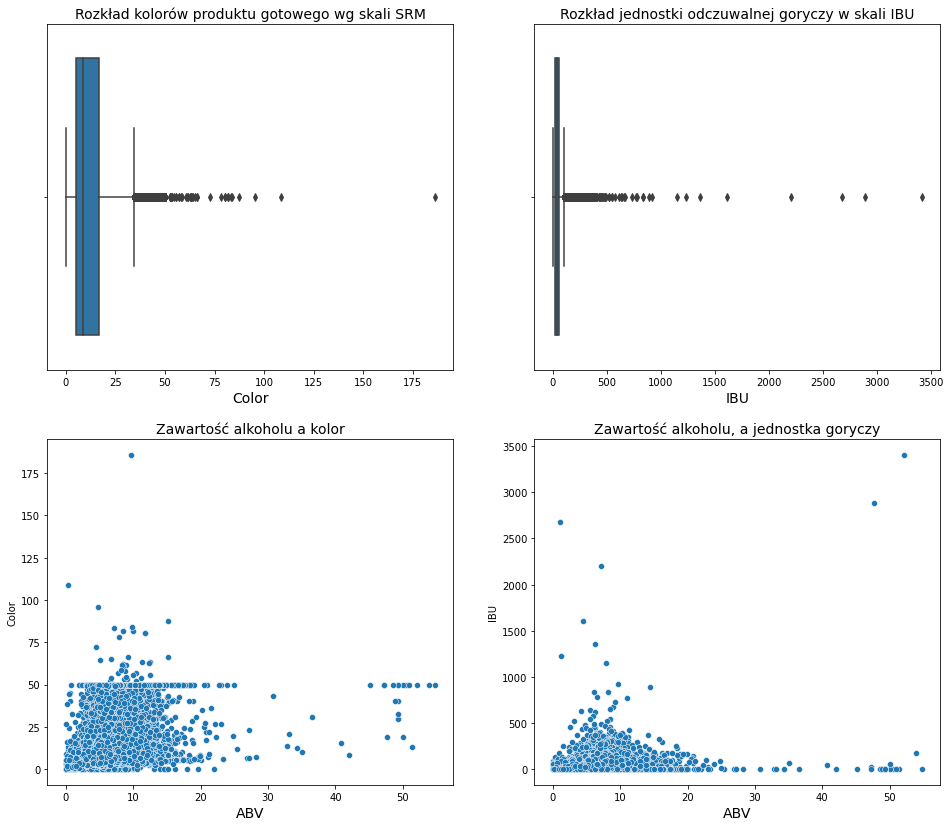

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
sns.boxplot(data = df_scaled, x='Color', ax=axes[0,0])
axes[0,0].set_title('Rozkład kolorów produktu gotowego wg skali SRM',fontsize= 14)
axes[0,0].set_xlabel('Color', fontsize =14)

sns.boxplot(data = df_scaled, x='IBU', ax=axes[0,1])     
axes[0,1].set_title('Rozkład jednostki odczuwalnej goryczy w skali IBU',fontsize= 14)
axes[0,1].set_xlabel('IBU', fontsize =14)

sns.scatterplot(data = df_scaled,x='ABV', y='Color', ax=axes[1,0])
axes[1,0].set_title('Zawartość alkoholu a kolor',fontsize= 14)
axes[1,0].set_xlabel('ABV', fontsize =14)
#axes[1,0].set_ylabel(fontsize =14)

sns.scatterplot(data = df_scaled,x='ABV', y='IBU', ax=axes[1,1])
axes[1,1].set_title('Zawartość alkoholu, a jednostka goryczy',fontsize= 14)
axes[1,1].set_xlabel('ABV', fontsize =14)
#axes[1,1].set_ylabel(fontsize =14)

plt.show()


In [21]:
pd.concat([df_scaled.iloc[:,9:11].quantile(q=0.95).rename('Percentyl 95'),\
           df_scaled.iloc[:,9:11].quantile(q=0.975).rename('Percentyl 97.5') \
          ,df_scaled.iloc[:,9:11].quantile(q=0.99).rename('Percentyl 99')],axis = 1)

,Percentyl 95,Percentyl 97.5,Percentyl 99
IBU,104.68,129.750,175.77
Color,40.00,47.655,50.00


In [22]:
len(df_scaled[df_recipe.Color>=50])

1553

Wnioskując na podstawie wykresów pudełkowych zmiennych Color oraz IBU, wnioskuje się istnienie wielu skrajnych wartości. Poniżej wykresów pudełkowych zostały wygenerowane wykresy punktowe aby sprawdzić czy istnieje korelacja tych wartości z wartościami zmiennej modelowanej ABV. Na podstawie wykresów punktowych i wartości korelacji można stwierdzić, że nie są to zmienne silnie zależne, zatem w celu pozbycia się wartości skrajnych usunięte zostaną receptury, gdzie IBU>105 oraz Color >40. Jednocześnie wybór punktu odcięcia koloru jest równy maksymalnej wartości przyjętej skali SRM.

#### Zmienna BoilTime

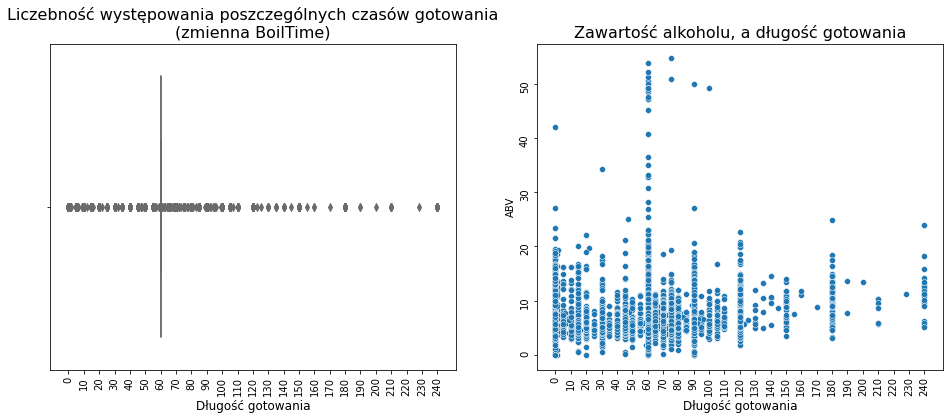

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#sns.palplot(sns.husl_palette(10, h=.5))
sns.boxplot(data = df_scaled, x = 'BoilTime',palette = sns.husl_palette(1,h=1), ax = axes[0])
axes[0].set_xticks(np.arange(0,250,10))
axes[0].tick_params(labelrotation=90)
#axes[0].set_xticklabels([np.arange(0,250,10)],rotation=90, fontsize = 14)
axes[0].set_title('Liczebność występowania poszczególnych czasów gotowania\n(zmienna BoilTime)', fontsize = 16)
axes[0].set_xlabel('Długość gotowania',fontsize = 12)


sns.scatterplot(data = df_scaled,x='BoilTime', y='ABV', ax=axes[1])
axes[1].set_title('Zawartość alkoholu, a długość gotowania',fontsize= 16)
axes[1].set_xlabel('Długość gotowania', fontsize =12)
axes[1].set_xticks(np.arange(0,250,10))
axes[1].set_yticks(np.arange(0,60,10))
axes[1].tick_params(labelrotation=90)

plt.show()

In [236]:
pd.concat([df_scaled.iloc[:,14:15].quantile(q=0.05).rename('Percentyl 5'),\
           df_scaled.iloc[:,14:15].quantile(q=0.95).rename('Percentyl 95'),\
          df_scaled.iloc[:,14:15].quantile(q=0.99).rename('Percentyl 99')],axis = 1)

,Percentyl 5,Percentyl 95,Percentyl 99
Efficiency,35.0,80.0,88.0


In [242]:
df_scaled.BoilTime.describe()

count    73861.000000
mean        65.074870
std         15.024228
min          0.000000
25%         60.000000
50%         60.000000
75%         60.000000
max        240.000000
Name: BoilTime, dtype: float64

In [246]:
len(df_scaled[(df_scaled.BoilTime < 60 )|(df_scaled.BoilTime>90)])

3128

Wykres pudełkowy zmiennej BoilTime wskazują na obecność dużej liczby skrajnych wartości. Wykres punktowy zmiennej BoilTime z zawartością alkoholu wskazuje, że nie istnieje zależność między skrajnymi wartościami BoilTime, a obecnością nadzwyczajnej zawartości alkoholu w gotowym produkcie. Na podstawie rozkładu centylowego, zmienna zostanie ograniczona do wartośći <60;90> (3128 zmiennych usuniętych).

#### Zmienna Efficiency

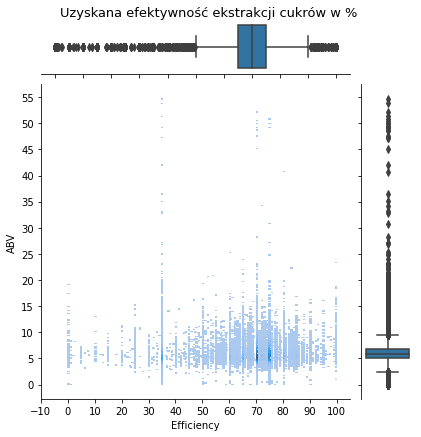

In [26]:
#sns.histplot(data = df_recipe,x='Efficiency', y='ABV',binwidth = 10,cbar=True,legend = True,multiple='stack')
#plt.title('Zawartość alkoholu, a uzyskana wydajność z cukru',fontsize= 14)
g = sns.JointGrid(data = df_scaled,x='Efficiency', y='ABV')
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)
g.fig.suptitle('Uzyskana efektywność ekstrakcji cukrów w %',fontsize= 13, x= 0.5, y=1.005)
g.ax_joint.set_xticks(np.arange(-10,110,10))
g.ax_joint.set_yticks(np.arange(0,60,5))
plt.show()

In [27]:
pd.concat([df_scaled.iloc[:,12:13].quantile(q=0.05).rename('Percentyl 5'),\
           df_scaled.iloc[:,12:13].quantile(q=0.95).rename('Percentyl 95'),\
          df_scaled.iloc[:,12:13].quantile(q=0.99).rename('Percentyl 99')],axis = 1)

,Percentyl 5,Percentyl 95,Percentyl 99
BoilTime,60.0,90.0,100.0


In [28]:
len(df_scaled[(df_scaled.BoilTime < 60 )|(df_scaled.BoilTime>90)])

3128

Rozkład zmiennej Efficiency wskazuje na występowanie wielu wartości odstających, które jednak nie korelują bezpośrednio z nadzwyczajnymi wartościami w zmiennej zależnej ABV. Na podstawie wykresu i wartości centyli zmienna Efficiency zostanie ograniczona do wartości zawartych w przedziale <60;90>. Zabieg ten wyklucza 3128 jednostek.

#### Zmienna BrewMethod

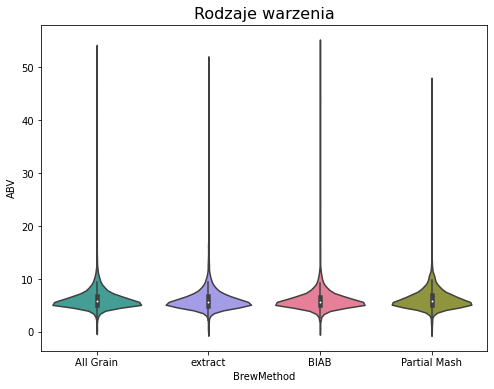

In [29]:
plt.figure(figsize=(8,6))
sns.violinplot(data = df_scaled,y='ABV',x = 'BrewMethod',palette = sns.husl_palette(4,h=1.5))
plt.title('Rodzaje warzenia', fontsize = 16)
plt.show()

In [30]:
levene(df_scaled.ABV[df_scaled.BrewMethod == 'All Grain'],\
                df_scaled.ABV[df_scaled.BrewMethod == 'extract'],\
                df_scaled.ABV[df_scaled.BrewMethod == 'BIAB'],\
                 df_scaled.ABV[df_scaled.BrewMethod == 'Partial Mash'])

LeveneResult(statistic=20.490814126617018, pvalue=2.8839297698892614e-13)

In [31]:
kruskal(df_scaled.ABV[df_scaled.BrewMethod == 'All Grain'],\
                df_scaled.ABV[df_scaled.BrewMethod == 'extract'],\
                df_scaled.ABV[df_scaled.BrewMethod == 'BIAB'],\
                 df_scaled.ABV[df_scaled.BrewMethod == 'Partial Mash'])

KruskalResult(statistic=142.98433573250261, pvalue=8.588877453399543e-31)

Wzrokowa ocena wizualizacji porównującej ilość alkoholu z rodzajem metody warzenia wskazuje na brak znaczących różnic w rozkładach, a jedynie występowanie długich ogonów spowodowanych skrajnymiw wartościami. Testy statystyczne wykazują, że podgrupy nie wykazują jednolitej wariancji i nie mają jednolitej średniej, co jednak może być spowodowane dużą liczebnością próbek. Zmienna ta, nie zostanie w żaden sposób ograniczona.

### Część II - Analiza eksploracyjna zmiennych z brakami oraz imputacja danych

In [32]:
count_missing = df_recipe.isnull().sum().rename('Liczba braków')
perc_missing = round((df_recipe.isnull().sum()/len(df_recipe)),4)*100
perc_missing = perc_missing.rename('% braków w zmiennej')
df_miss = pd.concat([count_missing,perc_missing],axis =1)
df_miss[df_miss['Liczba braków']> 1]

,Liczba braków,% braków w zmiennej
Style,596,0.81
BoilGravity,2990,4.05
MashThickness,29864,40.43
PitchRate,39252,53.14
PrimaryTemp,22662,30.68
PrimingMethod,67095,90.84
PrimingAmount,69087,93.54
UserId,50490,68.36


#### Imputacja zmiennych przy pomocy metody K najbliższych sąsiadów

In [50]:
df_scaled.columns

Index(['BeerID', 'Name', 'URL', 'Style', 'StyleID', 'Size_L', 'OG', 'FG',
       'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity',
       'Efficiency', 'MashThickness', 'SugarScale', 'BrewMethod', 'PitchRate',
       'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'UserId',
       'OG_Specific', 'FG_Specific', 'BoilGravity_Specific'],
      dtype='object')

Zmienne PrimingMethod oraz Priming Amount zostaną pominięte ze względu na wysoką unikalność każdej z wartości i bardzo dużą liczbę braków. Będą one osobno przeanalizowane, aby dowiedzieć się czy powinny w ogóle pozostać w zbiorze danych.

In [53]:
le = LabelEncoder()
features = df_scaled.loc[:,['Style','Size_L', 'OG_Specific', 'FG_Specific', 'BoilGravity_Specific','BrewMethod',\
                           'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime','Efficiency', 'MashThickness',\
                           'PitchRate','PrimaryTemp']].copy()
features.head()

,Style,Size_L,OG_Specific,FG_Specific,BoilGravity_Specific,BrewMethod,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,MashThickness,PitchRate,PrimaryTemp
0,Cream Ale,21.77,1.055,1.013,1.038,All Grain,5.48,17.65,4.83,28.39,75,70.0,NaN,NaN,17.78
1,Holiday/Winter Special Spiced Beer,20.82,1.083,1.021,1.070,All Grain,8.16,60.65,15.64,24.61,60,70.0,NaN,NaN,NaN
2,American IPA,18.93,1.063,1.018,NaN,extract,5.91,59.25,8.98,22.71,60,70.0,NaN,NaN,NaN
3,American IPA,22.71,1.061,1.017,NaN,All Grain,5.80,54.48,8.50,26.50,60,70.0,NaN,NaN,NaN
4,Belgian Blond Ale,50.00,1.060,1.010,1.050,All Grain,6.48,17.84,4.57,60.00,90,72.0,NaN,NaN,19.00


In [55]:
for feat in features.columns[[0,5]]:
    print(feat)
    features[feat] = le.fit_transform(features[feat].astype(str))

Style
BrewMethod


,Style,Size_L,OG_Specific,FG_Specific,BoilGravity_Specific,BrewMethod,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,MashThickness,PitchRate,PrimaryTemp
0,44,21.77,1.055,1.013,1.038,0,5.48,17.65,4.83,28.39,75,70.0,NaN,NaN,17.78
1,84,20.82,1.083,1.021,1.070,0,8.16,60.65,15.64,24.61,60,70.0,NaN,NaN,NaN
2,6,18.93,1.063,1.018,NaN,3,5.91,59.25,8.98,22.71,60,70.0,NaN,NaN,NaN
3,6,22.71,1.061,1.017,NaN,0,5.80,54.48,8.50,26.50,60,70.0,NaN,NaN,NaN
4,19,50.00,1.060,1.010,1.050,0,6.48,17.84,4.57,60.00,90,72.0,NaN,NaN,19.00


In [58]:
def impute_with_KNN(encoded_df_with_nulls,neighbors = 1):
    imputer = KNNImputer(n_neighbors = neighbors)
    cols = [encoded_df_with_nulls.columns]
    imputed_array = imputer.fit_transform(encoded_df_with_nulls)
    imputed_df = pd.DataFrame(imputed_array, columns = cols)
    return imputed_df

In [59]:
imp_KNN_1 = impute_with_KNN(features)
imp_KNN_5 = impute_with_KNN(features, 5)
imp_KNN_10 = impute_with_KNN(features,10)

In [88]:
imp_KNN_5.columns = ['Style','Size_L', 'OG_Specific', 'FG_Specific',\
                                           'BoilGravity_Specific','BrewMethod','ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',\
                                           'Efficiency', 'MashThickness','PitchRate','PrimaryTemp']
imp_KNN_10.columns= ['Style','Size_L', 'OG_Specific', 'FG_Specific',\
                                           'BoilGravity_Specific','BrewMethod','ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',\
                                           'Efficiency', 'MashThickness','PitchRate','PrimaryTemp']
imp_KNN_1.columns= ['Style','Size_L', 'OG_Specific', 'FG_Specific',\
                                           'BoilGravity_Specific','BrewMethod','ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',\
                                           'Efficiency', 'MashThickness','PitchRate','PrimaryTemp']

#### Zmienna Style, StyleID

C:\Users\Marcel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


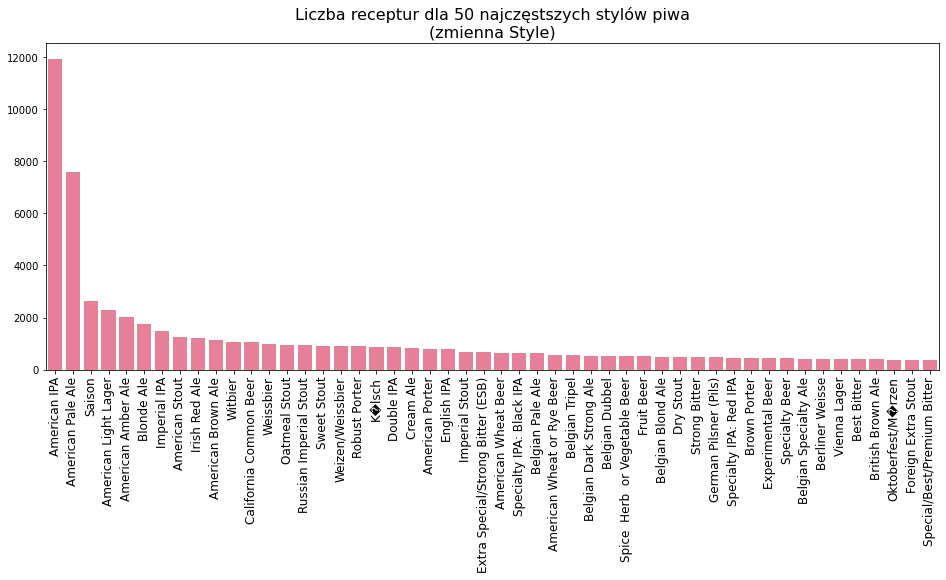

In [33]:
plt.figure(figsize=(16,6))
#sns.palplot(sns.husl_palette(10, h=.5))
sns.barplot(df_scaled.Style.value_counts().nlargest(50).index,df_scaled.Style.value_counts().nlargest(50).values,\
            palette = sns.husl_palette(1,h=2))
plt.xticks(rotation=90, fontsize = 12)
plt.title('Liczba receptur dla 50 najczęstszych stylów piwa\n(zmienna Style)', fontsize = 16)
plt.show()

Styl piwa definiowany jest przez sposób przygotowania, smak, kolor czy metodę produkcji, zatem kategoria wyznacza jest przez pozostałe zmienne i może zostać pominięta w dalszej analizie i w przypadku modelowania zmiennej ABV. W zbiorze danych występuję 175 unikatowych stylów piwa. Jednakże top 5 najczęstszych stylów (American IPA, American Pale Ale, Saison, American Light Lager, American Amber Ale) występuje w ponad 35% receptur. Zmienna StyleID nie wykazuje braków, gdyż Styl o nazwie NULL ma swoje własne ID, które jest jedynie wartością zastępczą.

#### Zmienna BoilGravity

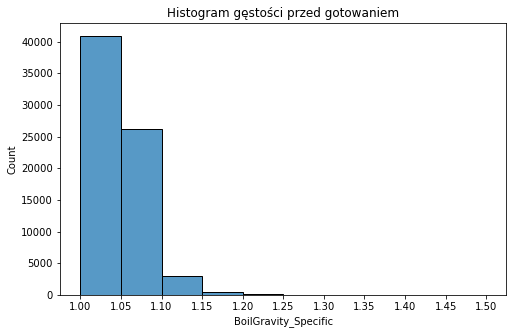

In [34]:
plt.figure(figsize = (8,5))
sns.histplot(data = df_scaled, x = 'BoilGravity_Specific',binwidth = 0.05)
plt.xticks(np.arange(1,1.51,0.05))
plt.title('Histogram gęstości przed gotowaniem')
plt.show()

In [36]:
imp_mean_BG = pd.DataFrame(df_scaled.BoilGravity_Specific.fillna(df_scaled.BoilGravity_Specific.mean()))
imp_median_BG = pd.DataFrame(df_scaled.BoilGravity_Specific.fillna(df_scaled.BoilGravity_Specific.median()))
#kodowanie zmiennych aby móc wykorzystać wszystkie wartości w klasyfikatorze


In [66]:
pd.concat([df_scaled.BoilGravity_Specific.describe().rename('BG without nulls'),\
          imp_mean_BG.BoilGravity_Specific.describe().rename('BG - mean imput'),\
          imp_median_BG.BoilGravity_Specific.describe().rename('BG - median imput'),\
          imp_KNN_1.BoilGravity_Specific.describe().squeeze().rename('BG - KNN n=1 imput'),\
          imp_KNN_5.BoilGravity_Specific.describe().squeeze().rename('BG - KNN n=5 imput'),\
          imp_KNN_10.BoilGravity_Specific.describe().squeeze().rename('BG - KNN n=10 imput')], axis = 1)

,BG without nulls,BG - mean imput,BG - median imput,BG - KNN n=1 imput,BG - KNN n=5 imput,BG - KNN n=10 imput
count,70871.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000
mean,1.053498,1.053498,1.053235,1.053641,1.053613,1.053591
std,0.027301,0.026743,0.026774,0.027325,0.027071,0.027009
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.040000,1.040000,1.040000,1.040000,1.040000,1.040000
50%,1.047000,1.048000,1.047000,1.047000,1.047000,1.047000
75%,1.058000,1.057000,1.057000,1.058000,1.058000,1.058000
max,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000


Magenta kolor - dane imputowane KNN n=1
Zielony kolor - dane oryginalne bez braków


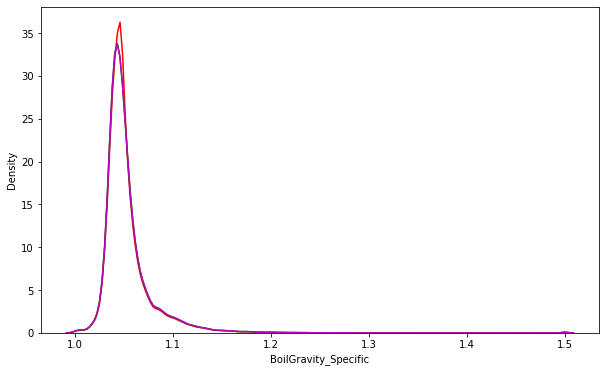

In [107]:
plt.figure(figsize=(10,6))
p3 = sns.kdeplot(data = imp_median_BG, x = 'BoilGravity_Specific', color = 'r')
p1 = sns.kdeplot(data = df_scaled, x = 'BoilGravity_Specific', color = 'g')
p4 = sns.kdeplot(data = imp_KNN_1, x = 'BoilGravity_Specific', color = 'm')

print('Magenta kolor - dane imputowane KNN n=1\nZielony kolor - dane oryginalne bez braków')

Tabela statysyk wskazuje, że imputacja zmiennej przy pomocy metody najbliższego sąsiada w najniższym stopniu wpływa na zmianę statystyk opisowych i zatem zostanie wykorzystana do imputacji tej zmiennej. Na wykresie rozkład oryginalny zmiennych jest ledwo widoczny, gdyż imputacja metodą najbliższego sąsiada nie zaburza go w znacznym stopniu.

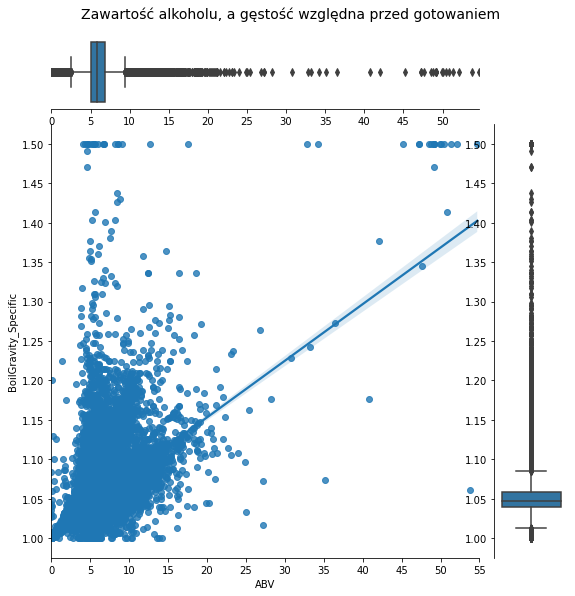

In [95]:
g = sns.JointGrid(data = imp_KNN_1,x='ABV', y='BoilGravity_Specific',height = 8)
g.plot_joint(sns.regplot)
g.plot_marginals(sns.boxplot)

g.fig.suptitle('Zawartość alkoholu, a gęstość względna przed gotowaniem',fontsize= 14, x= 0.5, y=1.03)
g.ax_joint.set_yticks(np.arange(1,1.51,0.05))
g.ax_joint.set_xticks(np.arange(0,60,5))
g.ax_marg_x.tick_params(labelbottom=True)
g.ax_marg_y.tick_params(labelleft=True)
plt.show()


In [96]:
len(imp_KNN_10[imp_KNN_10.BoilGravity_Specific > 1.1])

3780

W celu ograniczenia liczby obserwacji skrajnych zmienna BoilGravity_Specific zostanie ograniczona do obserwacji poniżej 1.1 gęstości względnej. Rozkład tej zmiennej i zmiennej ABV wskazuje na pewną zależność między wysokimi wartościami BoilGravity i ABV. Natomiast może to być spowodowane przez bardzo skrajne wartości obserwacji około 50% ABV. Ograniczenie zmiennej spowoduje wykluczenie 3780 jednostek.

#### Zmienna MashThickness

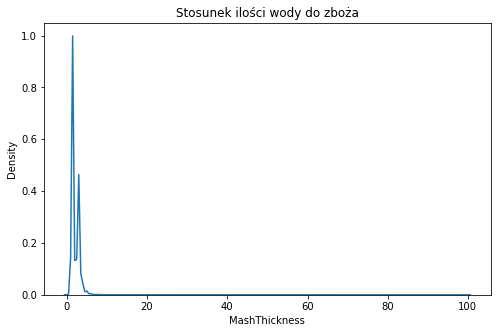

In [136]:
plt.figure(figsize = (8,5))
sns.kdeplot(data = df_scaled,x = 'MashThickness')
plt.title('Stosunek ilości wody do zboża')
plt.show()

In [127]:
df_scaled.MashThickness.describe()

count    43997.000000
mean         2.127235
std          1.682347
min          0.000000
25%          1.500000
50%          1.500000
75%          3.000000
max        100.000000
Name: MashThickness, dtype: float64

In [133]:
df_scaled.MashThickness.value_counts()

1.50000    15499
3.00000     8312
1.25000     4923
2.50000     1864
1.30000     1110
           ...  
3.66000        1
2.62500        1
0.36800        1
6.67761        1
3.51000        1
Name: MashThickness, Length: 567, dtype: int64

In [135]:
df_scaled[df_scaled.MashThickness == 1.5]

,BeerID,Name,URL,Style,StyleID,Size_L,OG,FG,ABV,IBU,...,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId,OG_Specific,FG_Specific,BoilGravity_Specific
20,21,Goose Island IPA Clone,/homebrew/recipe/view/28343/goose-island-ipa-clone,English IPA,65,20.82,1.065,1.015,6.63,55.52,...,Specific Gravity,All Grain,NaN,17.78,NaN,NaN,5889.0,1.065,1.015,1.048
32,33,New England IPA,/homebrew/recipe/view/425217/new-england-ipa,American IPA,7,19.87,1.071,1.018,6.93,68.91,...,Specific Gravity,All Grain,1.00,20.00,NaN,NaN,25649.0,1.071,1.018,1.050
35,36,The Devil is in the Details (Duvel Clone)...,/homebrew/recipe/view/61925/the-devil-is-in-the-details-duvel-clone-,Belgian Golden Strong Ale,23,41.64,1.069,1.005,8.40,40.71,...,Specific Gravity,All Grain,1.00,17.78,Force Carb,30 PSI,15241.0,1.069,1.005,1.058
51,52,Simple Citra IPA - One Gallon,/homebrew/recipe/view/231072/simple-citra-ipa-one-gallon,American IPA,7,3.79,1.058,1.011,6.10,37.06,...,Specific Gravity,All Grain,0.35,18.33,NaN,NaN,45128.0,1.058,1.011,1.039
52,53,Hoegaarden Clone,/homebrew/recipe/view/217598/hoegaarden-clone,Weizen/Weissbier,170,20.82,1.052,1.013,5.18,13.50,...,Specific Gravity,All Grain,NaN,21.11,NaN,NaN,NaN,1.052,1.013,1.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73832,73833,Experimental Nordic Pine Saison,/homebrew/recipe/view/620846/experimental-nordic-pine-saison,Saison,134,20.82,1.065,1.021,5.75,91.60,...,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN,1.065,1.021,1.048
73839,73840,NZ IPA,/homebrew/recipe/view/612208/nz-ipa,American IPA,7,20.82,1.065,1.014,6.73,43.04,...,Specific Gravity,All Grain,NaN,20.00,NaN,NaN,102447.0,1.065,1.014,1.055
73841,73842,Braumeister IPA 200L,/homebrew/recipe/view/620695/braumeister-ipa-200l,American IPA,7,200.00,1.046,1.008,4.94,238.63,...,Specific Gravity,All Grain,0.35,20.00,NaN,NaN,101530.0,1.046,1.008,1.045
73844,73845,Easy pale ale,/homebrew/recipe/view/620737/easy-pale-ale,American Light Lager,9,20.82,1.046,1.011,4.52,0.00,...,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN,1.046,1.011,1.034


Analiza pojedyńczych wartości zmiennej wskazuje, że została ona pobrana bez uwzględnienia wykorzystywanej jednostki pomiaru, a zatem nie jest możliwe stwierdzenie czy dana wartość w recepturze liczona jest w litrach na kilogram czy w kwartach na funt. Zmienna ta ze względu na tę wadę zostanie całkowicie wykluczona z modelowania, gdyż uniemożliwia to prawidłową interpretację.

#### Zmienna PitchRate

In [137]:
df_scaled.PitchRate.describe()

count    34609.000000
mean         0.750468
std          0.394262
min          0.000000
25%          0.350000
50%          0.750000
75%          1.000000
max          2.000000
Name: PitchRate, dtype: float64

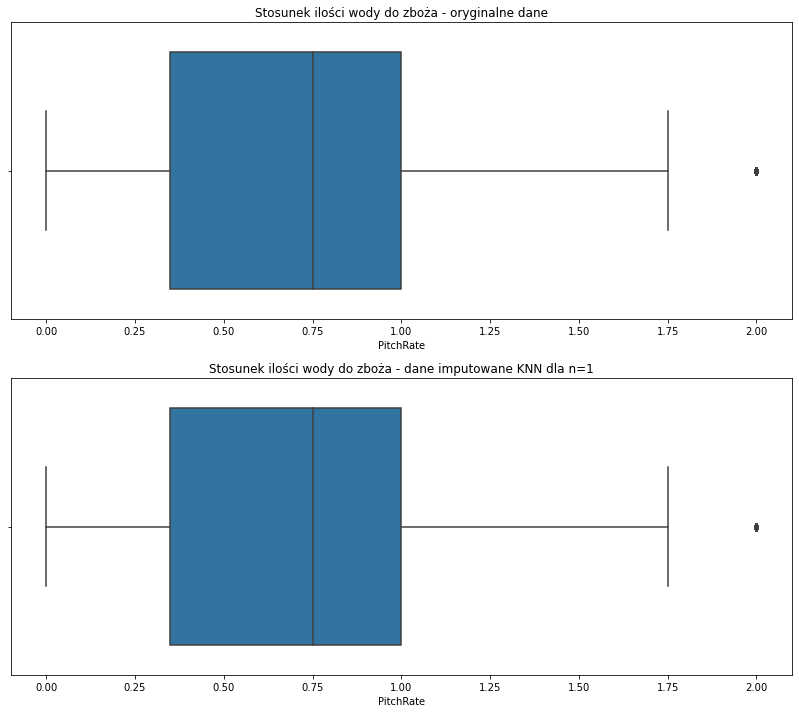

In [153]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

sns.boxplot(data = df_scaled,x = 'PitchRate',ax = axes[0])
axes[0].set_title('Stosunek ilości wody do zboża - oryginalne dane')
sns.boxplot(data = imp_KNN_1,x = 'PitchRate',ax = axes[1])
axes[1].set_title('Stosunek ilości wody do zboża - dane imputowane KNN dla n=1')
plt.show()

In [142]:
imp_mean_pitch = pd.DataFrame(df_scaled.PitchRate.fillna(df_scaled.PitchRate.mean()))
imp_median_pitch = pd.DataFrame(df_scaled.PitchRate.fillna(df_scaled.PitchRate.median()))

In [144]:
pd.concat([df_scaled.PitchRate.describe().rename('PitchRate without nulls'),\
          imp_mean_pitch.PitchRate.describe().rename('PitchRate - mean imput'),\
          imp_median_pitch.PitchRate.describe().rename('PitchRate - median imput'),\
          imp_KNN_1.PitchRate.describe().squeeze().rename('PitchRate - KNN n=1 imput'),\
          imp_KNN_5.PitchRate.describe().squeeze().rename('PitchRate - KNN n=5 imput'),\
          imp_KNN_10.PitchRate.describe().squeeze().rename('PitchRate - KNN n=10 imput')], axis = 1)

,PitchRate without nulls,PitchRate - mean imput,PitchRate - median imput,PitchRate - KNN n=1 imput,PitchRate - KNN n=5 imput,PitchRate - KNN n=10 imput
count,34609.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000
mean,0.750468,0.750468,0.750219,0.728902,0.730380,0.731055
std,0.394262,0.269879,0.269879,0.382650,0.313001,0.301836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350000,0.750000,0.750000,0.350000,0.500000,0.515000
50%,0.750000,0.750468,0.750000,0.750000,0.700000,0.705000
75%,1.000000,0.750468,0.750000,1.000000,0.850000,0.825000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [175]:
pd.concat([imp_KNN_1.iloc[:,13:14].quantile(q=0.05).rename('Percentyl 5'),\
           imp_KNN_1.iloc[:,13:14].quantile(q=0.25).rename('Percentyl 25'),\
           imp_KNN_1.iloc[:,13:14].quantile(q=0.95).rename('Percentyl 95'),\
          imp_KNN_1.iloc[:,13:14].quantile(q=0.99).rename('Percentyl 99')],axis = 1)

,Percentyl 5,Percentyl 25,Percentyl 95,Percentyl 99
PitchRate,0.35,0.35,1.5,2.0


In [184]:
len(imp_KNN_1[imp_KNN_1.PitchRate<0.35])

94

In [185]:
len(imp_KNN_1[imp_KNN_1.PitchRate>1.5])

2205

Ponownie imputacja metodą najbliższego sąsiada wydaje się w najmniejszym stopniu wpływać na zmiany statystyk rozkładu zmiennej. Wartości 0 zmiennej wskazują również na braki danych, aby ograniczyć wartości do tych prawidłowych, wartości zostaną odcięte na podstawie percentyli -  <0.35;1.5>.

#### Zmienna PrimaryTemp

Kolor niebieski - dane oryginalne bez uwzględnienia braków
Kolor czerwony - dane po imputacji KNN dla n = 1


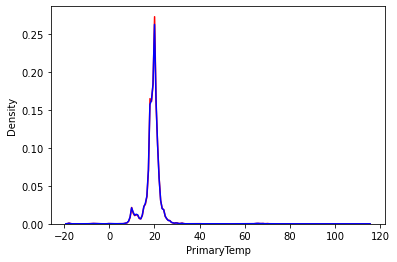

In [189]:
p1 = sns.kdeplot(data = imp_KNN_1,x='PrimaryTemp', color = 'r')
p2 = sns.kdeplot(data = df_scaled,x='PrimaryTemp', color = 'b')
print('Kolor niebieski - dane oryginalne bez uwzględnienia braków\nKolor czerwony - dane po imputacji KNN dla n = 1')

In [191]:
imp_mean_prim = pd.DataFrame(df_scaled.PrimaryTemp.fillna(df_scaled.PrimaryTemp.mean()))
imp_median_prim = pd.DataFrame(df_scaled.PrimaryTemp.fillna(df_scaled.PrimaryTemp.median()))

In [194]:
pd.concat([df_scaled.PrimaryTemp.describe().rename('PrimaryTemp without nulls'),\
          imp_mean_prim.PrimaryTemp.describe().rename('PrimaryTemp - mean imput'),\
          imp_median_prim.PrimaryTemp.describe().rename('PrimaryTemp - median imput'),\
          imp_KNN_1.PrimaryTemp.describe().squeeze().rename('PrimaryTemp - KNN n=1 imput'),\
          imp_KNN_5.PrimaryTemp.describe().squeeze().rename('PrimaryTemp - KNN n=5 imput'),\
          imp_KNN_10.PrimaryTemp.describe().squeeze().rename('PrimaryTemp - KNN n=10 imput')], axis = 1)

,PrimaryTemp without nulls,PrimaryTemp - mean imput,PrimaryTemp - median imput,PrimaryTemp - KNN n=1 imput,PrimaryTemp - KNN n=5 imput,PrimaryTemp - KNN n=10 imput
count,51199.000000,73861.000000,73861.000000,73861.000000,73861.000000,73861.000000
mean,19.175641,19.175641,19.428570,19.230226,19.222266,19.216561
std,4.219676,3.513184,3.533694,4.254101,3.720996,3.653124
min,-17.780000,-17.780000,-17.780000,-17.780000,-17.780000,-17.780000
25%,18.000000,18.890000,18.890000,18.000000,18.330000,18.330000
50%,20.000000,19.175641,20.000000,20.000000,19.666000,19.600000
75%,20.000000,20.000000,20.000000,20.560000,20.222000,20.077000
max,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000


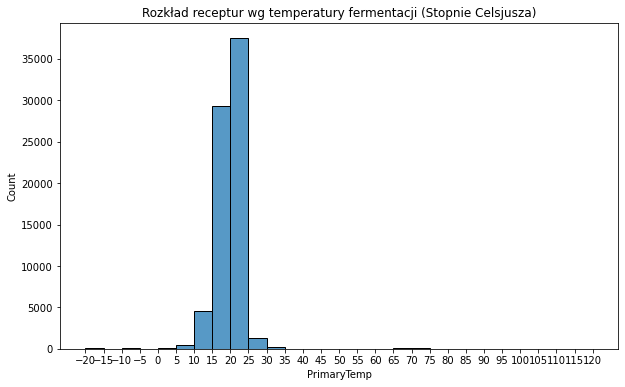

In [217]:
plt.figure(figsize = (10,6))
sns.histplot(data=imp_KNN_1,x='PrimaryTemp', binwidth = 5,binrange=(-20,120))
plt.xticks(np.arange(-20,125,5))
plt.title('Rozkład receptur wg temperatury fermentacji (Stopnie Celsjusza)')
plt.show()

In [235]:
len(imp_KNN_1[(imp_KNN_1.PrimaryTemp<5)|(imp_KNN_1.PrimaryTemp>35)])

464

Wartości zmiennej poniżej zera oraz powyżej 60 stopni nie mają uzasadnienia w fermentacji. Na podstawie rozkładu zmienna zostanie ograniczona do wartości z przedziału 5 do 35 stopni, co wykluczy 464 obserwacje skrajne.

#### Zmienna PrimingMethod, PrimingAmount

In [226]:
df_scaled.PrimingMethod.value_counts()[:20]

Corn Sugar            715
Dextrose              503
corn sugar            360
Keg                   330
Sugar                 312
Sukkerlake            310
dextrose              246
Corn sugar            220
CO2                   185
sugar                 162
Force Carb            125
Table Sugar           113
keg                    96
Forced                 92
DME                    92
Table sugar            90
Force                  88
Priming Sugar          79
Forced Carbonation     73
Bottle                 71
Name: PrimingMethod, dtype: int64

In [224]:
df_scaled.PrimingAmount.value_counts()[:20]

5 oz            205
3/4 cup         110
4 oz            106
1 cup           102
5oz              92
4oz              80
6 g sukker/l     53
5 oz.            43
6g/l             39
6                38
5 g sukker/l     36
4.5 oz           35
3.5 oz           34
7g/l             31
5                30
12 psi           30
6 g/l            27
100g             27
120g             26
3/4 Cup          25
Name: PrimingAmount, dtype: int64

In [231]:
count_missing = df_recipe.isnull().sum().rename('Liczba braków')
perc_missing = round((df_recipe.isnull().sum()/len(df_recipe)),4)*100
perc_missing = perc_missing.rename('% braków w zmiennej')
pd.concat([count_missing,perc_missing],axis =1)[20:22]

,Liczba braków,% braków w zmiennej
PrimingMethod,67095,90.84
PrimingAmount,69087,93.54


Zmienna PrimingMethod oraz Priming Amount wykazują się ponad 90% brakiem danych oraz bardzo wysoką unikalnością wartości ze względu na skalę i ilość. W związku z tym nie można ustalić ani w żaden sposób zaimputować takich zmianych jakościowych i zmienne zostaną pominięte w modelowaniu.

### Wybór zmiennych i jednostek do badania

Ostatnim krokiem jest ograniczenie i wylosowanie zmiennych do modelowania. Tablicą danych wykorzystaną w badaniu będzie tablica zaimputowana metodą najbliższego sąsiada, gdyż wykazywała się ona w przypadku każdej zmiennej z brakami, najniższymi różnicami statystyk opisowych od statystyk dla zbioru z wykluczeniem braków.

In [43]:
df_sans_outlier = imp_KNN_1[]

,Liczba braków,% braków w zmiennej
BeerID,0,0.00
Name,1,0.00
URL,0,0.00
Style,596,0.81
StyleID,0,0.00
Size_L,0,0.00
OG,0,0.00
FG,0,0.00
ABV,0,0.00
IBU,0,0.00


In [232]:
imp_KNN_1.columns

Index(['Style', 'Size_L', 'OG_Specific', 'FG_Specific', 'BoilGravity_Specific',
       'BrewMethod', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'Efficiency', 'MashThickness', 'PitchRate', 'PrimaryTemp'],
      dtype='object')

Efficiency zostanie ograniczona do wartości zawartych w przedziale <60;90>

 percentyli -  <0.35;1.5> PitchRate

gdzie IBU>105 oraz Color >40. 

160L gotowanego produktu, a więc według 97.5 percentyla zmiennej BoilSize

BoilGravity_Specific zostanie ograniczona do obserwacji poniżej 1.1

primary temp - len(imp_KNN_1[(imp_KNN_1.PrimaryTemp<5)|(imp_KNN_1.PrimaryTemp>35)])